In [2]:
# python
import sys
import os
import importlib
import numpy as np
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
# sidm_path = str(sys.path[0]).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, cutflow
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from tqdm.notebook import tqdm

In [3]:
client = scaleout.make_dask_client("tls://localhost:8786")
client

Connection method: Direct,
Dashboard: /user/dongyub.lee@cern.ch/proxy/8787/status,
Comm: tls://192.168.121.138:8786,Workers: 0
Dashboard: /user/dongyub.lee@cern.ch/proxy/8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


In [4]:
samples = [
    "2Mu2E_500GeV_5p0GeV_0p08mm",
    "4Mu_500GeV_5p0GeV_0p08mm",
    "TTJets",
]

In [4]:
fileset = utilities.make_fileset(samples[:1], 
                                 "llpNanoAOD_v2", 
                                 location_cfg="signal_2mu2e_v10.yaml",
                                 max_files = 1,
                                )

fileset = utilities.make_fileset(samples[1:2], 
                                 "llpNanoAOD_v2",
                                 location_cfg="signal_4mu_v10.yaml",
                                fileset=fileset,
                                max_files = 1, 
                                #max_files =1, 
                                )

fileset = utilities.make_fileset(samples[2:3], 
                                 "skimmed_llpNanoAOD_v2",
                                 location_cfg="backgrounds.yaml",
                                fileset=fileset,
                                max_files = 1, 
                                #max_files =1, 
                                )

In [ ]:
runner = processor.Runner(
    executor=processor.DaskExecutor(client=client),
    # executor=processor.IterativeExecutor(),
    # executor=processor.FuturesExecutor(), 
    schema=NanoAODSchema,
#    maxchunks=10, 
    skipbadfiles=True
)

channels = [
    "base",
]

p = sidm_processor.SidmProcessor(
    channels,
    ["isolation_base", "lj_lj_base", "abcd_base", "lj_base", "displacement_base"],
    lj_reco_choices=["0.4"],
    unweighted_hist=True,
)

import coffea.util as coffea_util
coffea_util.save(p, "processor.coffea")
print(coffea_util.load("processor.coffea"))
with performance_report(filename="dask-report.html"):
    output = runner.run(fileset, treename="Events", processor_instance=p)

out = output["out"]

[                                        ] | 0% Completed |  2min 26.5s

In [6]:
samples_2mu2e = [
    "2Mu2E_500GeV_5p0GeV_0p08mm",
    "TTJets"
]

samples_4mu = [    
    "4Mu_500GeV_5p0GeV_0p08mm",
    "TTJets"
]

Text(0.5, 1.0, 'TTJets')

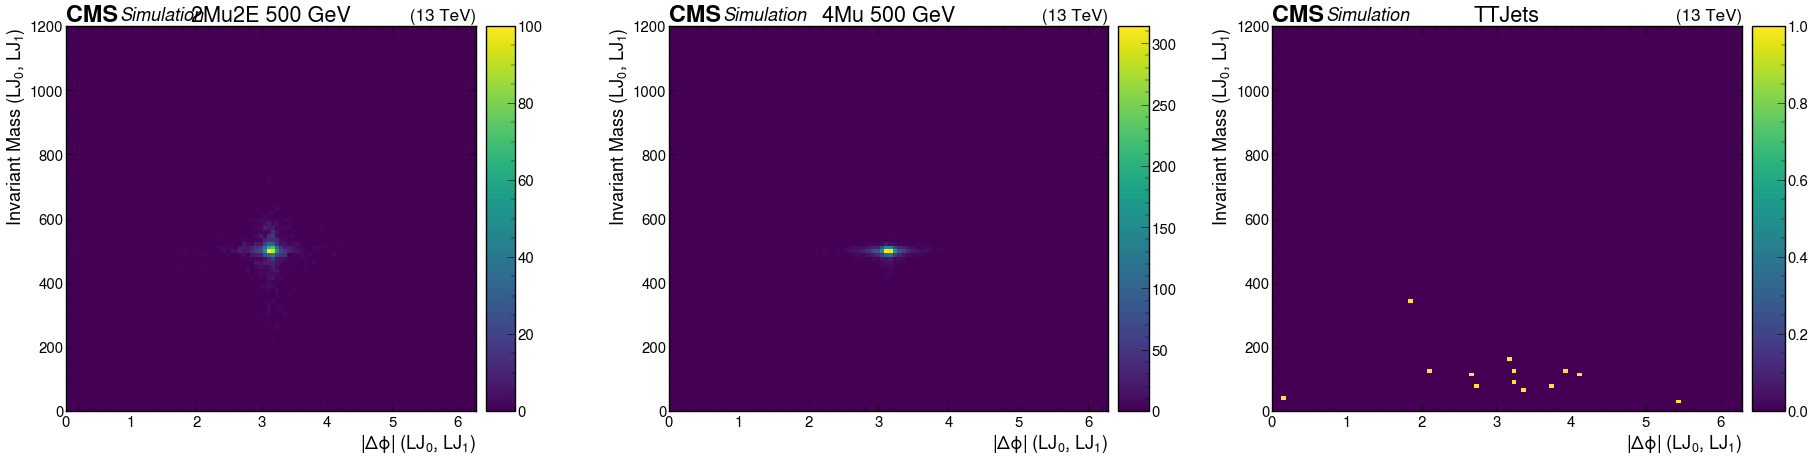

In [7]:
SIG_2mu = output["out"][samples_2mu2e[0]]["hists"]
SIG_4mu = output["out"][samples_4mu[0]]["hists"]
BKG = output["out"][samples_2mu2e[1]]["hists"]

fig, axs = plt.subplots(1, 3, figsize=(36, 10))
plt.subplot(1,3,1)
utilities.plot(SIG_2mu["lj_lj_absdphi_invmass"][channels[0], :, :])
plt.title("2Mu2E 500 GeV")

plt.subplot(1,3,2)
utilities.plot(SIG_4mu["lj_lj_absdphi_invmass"][channels[0], :, :])
plt.title("4Mu 500 GeV")

plt.subplot(1,3,3)
utilities.plot(BKG["lj_lj_absdphi_invmass"][channels[0], :, :])
plt.title("TTJets")

In [9]:
import numpy as np

# Histogram inputs
sig_2mu = SIG_2mu["lj_lj_absdphi_invmass"].values(flow=False)[0]
sig_4mu = SIG_4mu["lj_lj_absdphi_invmass"].values(flow=False)[0]
bkg = BKG["lj_lj_absdphi_invmass"].values(flow=False)[0]

x_centers = SIG_2mu["lj_lj_absdphi_invmass"].axes[1].centers
y_centers = SIG_2mu["lj_lj_absdphi_invmass"].axes[2].centers

phi_bins = np.linspace(1.0, 3.0, 21)
mass_bins = np.linspace(300, 700, 21)

results = {
    "2mu": {"score": 0, "cuts": None, "stats": {}},
    "4mu": {"score": 0, "cuts": None, "stats": {}},
}

for phi_cut in phi_bins:
    for mass_cut in mass_bins:
        idx_phi_lo = np.where(x_centers < phi_cut)[0]
        idx_phi_hi = np.where(x_centers >= phi_cut)[0]
        idx_mass_lo = np.where(y_centers < mass_cut)[0]
        idx_mass_hi = np.where(y_centers >= mass_cut)[0]

        # background ABCD
        bkg_A = bkg[np.ix_(idx_phi_lo, idx_mass_lo)].sum()
        bkg_B = bkg[np.ix_(idx_phi_hi, idx_mass_lo)].sum()
        bkg_C = bkg[np.ix_(idx_phi_lo, idx_mass_hi)].sum()
        bkg_D = bkg[np.ix_(idx_phi_hi, idx_mass_hi)].sum()

        # 2mu signal ABCD
        sig_A = sig_2mu[np.ix_(idx_phi_lo, idx_mass_lo)].sum()
        sig_B = sig_2mu[np.ix_(idx_phi_hi, idx_mass_lo)].sum()
        sig_C = sig_2mu[np.ix_(idx_phi_lo, idx_mass_hi)].sum()
        sig_D = sig_2mu[np.ix_(idx_phi_hi, idx_mass_hi)].sum()

        if bkg_D > 0 and sig_D > 0:
            score = sig_D / np.sqrt(bkg_D)
            if score > results["2mu"]["score"]:
                results["2mu"] = {
                    "score": score,
                    "cuts": (phi_cut, mass_cut),
                    "stats": {
                        "sig_A": sig_A, "sig_B": sig_B, "sig_C": sig_C, "sig_D": sig_D,
                        "bkg_A": bkg_A, "bkg_B": bkg_B, "bkg_C": bkg_C, "bkg_D": bkg_D,
                        "total_evt": sig_A + sig_B + sig_C + sig_D + bkg_A + bkg_B + bkg_C + bkg_D,
                        "S/√B": score
                    }
                }

        # 4mu signal ABCD
        sig_A = sig_4mu[np.ix_(idx_phi_lo, idx_mass_lo)].sum()
        sig_B = sig_4mu[np.ix_(idx_phi_hi, idx_mass_lo)].sum()
        sig_C = sig_4mu[np.ix_(idx_phi_lo, idx_mass_hi)].sum()
        sig_D = sig_4mu[np.ix_(idx_phi_hi, idx_mass_hi)].sum()

        if bkg_D > 0 and sig_D > 0:
            score = sig_D / np.sqrt(bkg_D)
            if score > results["4mu"]["score"]:
                results["4mu"] = {
                    "score": score,
                    "cuts": (phi_cut, mass_cut),
                    "stats": {
                        "sig_A": sig_A, "sig_B": sig_B, "sig_C": sig_C, "sig_D": sig_D,
                        "bkg_A": bkg_A, "bkg_B": bkg_B, "bkg_C": bkg_C, "bkg_D": bkg_D,
                        "total_evt": sig_A + sig_B + sig_C + sig_D + bkg_A + bkg_B + bkg_C + bkg_D,
                        "S/√B": score
                    }
                }
# 출력
for channel in ["2mu", "4mu"]:
    cuts = results[channel]["cuts"]
    s = results[channel]["stats"]
    print(f"\nBest S/√B Cut for {channel} channel:")
    print(f"Δφ cut = {cuts[0]:.2f}, mass cut = {cuts[1]:.2f}")
    print(f"[Signal]     A: {s['sig_A']:.1f}, B: {s['sig_B']:.1f}, C: {s['sig_C']:.1f}, D: {s['sig_D']:.1f}")
    print(f"[Background] A: {s['bkg_A']:.1f}, B: {s['bkg_B']:.1f}, C: {s['bkg_C']:.1f}, D: {s['bkg_D']:.1f}")
    print(f"→ Signal total:     {s['sig_A'] + s['sig_B'] + s['sig_C'] + s['sig_D']:.1f}")
    print(f"→ Background total: {s['bkg_A'] + s['bkg_B'] + s['bkg_C'] + s['bkg_D']:.1f}")
    print(f"S/√B = {s['S/√B']:.3f}")



Best S/√B Cut for 2mu channel:
Δφ cut = 1.00, mass cut = 300.00
[Signal]     A: 0.0, B: 15.0, C: 2.0, D: 1574.0
[Background] A: 1.0, B: 11.0, C: 0.0, D: 1.0
→ Signal total:     1591.0
→ Background total: 13.0
S/√B = 1574.000

Best S/√B Cut for 4mu channel:
Δφ cut = 1.00, mass cut = 300.00
[Signal]     A: 0.0, B: 4.0, C: 2.0, D: 2946.0
[Background] A: 1.0, B: 11.0, C: 0.0, D: 1.0
→ Signal total:     2952.0
→ Background total: 13.0
S/√B = 2946.000


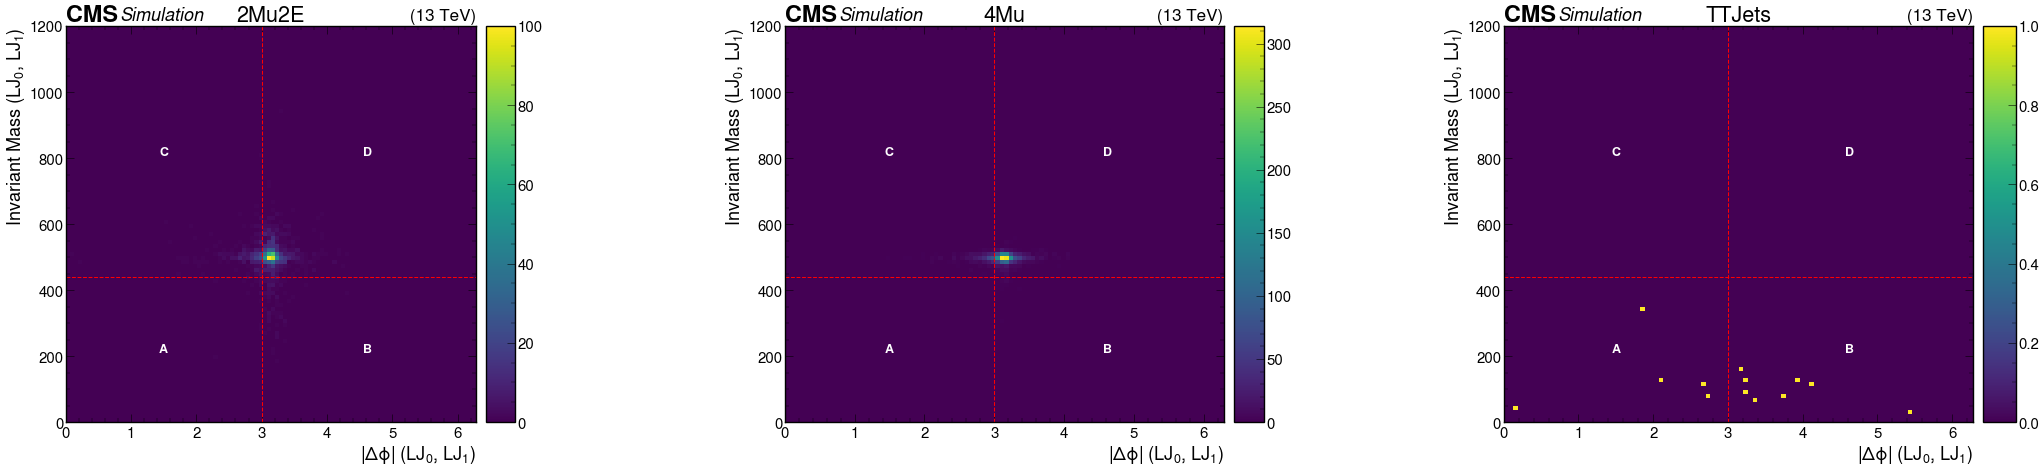

In [11]:
phi_cut = 3.0
mass_cut = 440.0

x_centers = SIG_2mu["lj_lj_absdphi_invmass"].axes[1].centers
y_centers = SIG_2mu["lj_lj_absdphi_invmass"].axes[2].centers

x_lo = phi_cut / 2
x_hi = phi_cut + (max(x_centers) - phi_cut) / 2
y_lo = mass_cut / 2
y_hi = mass_cut + (max(y_centers) - mass_cut) / 2

fig, axs = plt.subplots(1, 3, figsize=(36, 10))

# 2mu2e
plt.sca(axs[0])
utilities.plot(SIG_2mu["lj_lj_absdphi_invmass"][channels[0], :, :])
plt.axvline(phi_cut, color='red', linestyle='--')
plt.axhline(mass_cut, color='red', linestyle='--')
plt.text(x_lo, y_hi, "C", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.text(x_hi, y_hi, "D", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.text(x_lo, y_lo, "A", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.text(x_hi, y_lo, "B", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.title("2Mu2E")

# 2mu2e
plt.sca(axs[1])
utilities.plot(SIG_4mu["lj_lj_absdphi_invmass"][channels[0], :, :])
plt.axvline(phi_cut, color='red', linestyle='--')
plt.axhline(mass_cut, color='red', linestyle='--')
plt.text(x_lo, y_hi, "C", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.text(x_hi, y_hi, "D", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.text(x_lo, y_lo, "A", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.text(x_hi, y_lo, "B", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.title("4Mu")

# TTJets
plt.sca(axs[2])
utilities.plot(BKG["lj_lj_absdphi_invmass"][channels[0], :, :])
plt.axvline(phi_cut, color='red', linestyle='--')
plt.axhline(mass_cut, color='red', linestyle='--')
plt.text(x_lo, y_hi, "C", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.text(x_hi, y_hi, "D", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.text(x_lo, y_lo, "A", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.text(x_hi, y_lo, "B", fontsize=18, color='white', ha='center', va='center', fontweight='bold')
plt.title("TTJets")

plt.tight_layout()
plt.show()